In [1]:
import json
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.nan)

In [2]:
biz = pd.read_json('yelp_academic_dataset_business.json', lines=True)

In [3]:
biz = biz[['business_id', 'name', 'city', 'latitude', 'longitude']]
biz.dropna(axis=0, inplace=True)
minibiz = biz[:1000] # Make a smaller sample set for the sake of speed
biz.head()

,business_id,name,city,latitude,longitude
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,51.091813,-114.031675
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,Henderson,35.960734,-114.939821
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,MontrÃ©al,45.540503,-73.599300
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,Phoenix,33.449999,-112.076979
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,Calgary,51.035591,-114.027366


In [4]:
from math import sin, cos, sqrt, atan2, radians, degrees

def make_bounding_box(lat, lon, size):
    '''Given a pair of coordinates, make a bounding box [size] miles per side.'''
    r = size/2  # The distance to the sides from the center point
    df = r/69  # North-South distance in degrees
    lon_d = radians(lat) * 69.172 # one degree of longitude at this latitude
    #dl = df/cos(lat)  #East-west distance in degrees
    dl = r/lon_d
    
    w_lon = round(lon-dl, 6)
    s_lat = round(lat-df, 6)
    e_lon = round(lon+dl, 6)
    n_lat = round(lat+df, 6)
    return [w_lon, s_lat, e_lon, n_lat]

def in_bounding_box(lat, lon, box):
    '''Given a pair of coordinates and a bounding box, return True if that point is in that box'''
    if (lat > box[1] and lat < box[3]) and (lon > box[0] and lon < box[2]):
        return True
    else:
        return False

def get_num_in_box(box, lats, lons):
    '''Given a bounding box and lists of latitudes and longitudes, count the number of points in the box.'''
    num = 0
    for x in range(len(lats)):
        num += 1 if in_bounding_box(lats[x], lons[x], box) else 0
    return num

In [5]:
import csv
from geopy import distance
regions = {}
centers = []
i = 0
region_column = []

for idx, row in biz.iterrows():
    i += 1
    if centers:
        for x in range(len(centers)):
            p1 = (row['latitude'], row['longitude'])
            p2 = (centers[x][0], centers[x][1])
            if distance.distance(p1, p2).miles < 75:
                
                # Update the center point
                if len(regions[x]) < 30:
                    centers[x][0] = round(((centers[x][0] * len(regions[x])) + row['latitude'])/(len(regions[x]) + 1), 6)
                    centers[x][1] = round(((centers[x][1] * len(regions[x])) + row['longitude'])/(len(regions[x]) + 1), 6)

                # Add this point to this region
                if regions[x]:
                    regions[x].append(idx)
                else:
                    regions[x] = [idx]
                
                # Update the region list for adding to DF
                region_column.append(x)
                
                break
            
        else:
            # Make a new region
            new_region = len(centers)
            regions[new_region] = [idx]
            centers.append([row['latitude'], row['longitude']])
            region_column.append(new_region)
            
    else:
        regions[len(centers)] = [idx]
        region_column.append(len(centers))
        centers.append([row['latitude'], row['longitude']])
        
biz = biz.assign(region=region_column)

# Write the businesses with regional encoding to CSV
biz.to_csv('biz_locations_75.csv', index=False, columns=['business_id', 'name', 'city', 'latitude', 'longitude', 'region'])

In [5]:
# Read in CSV to reset biz variable rather than running that long-ass cell
biz = pd.read_csv('biz_locations_75.csv')
biz.head()

,business_id,name,city,latitude,longitude,region
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,51.091813,-114.031675,0
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,Henderson,35.960734,-114.939821,1
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,MontrÃ©al,45.540503,-73.599300,2
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,Phoenix,33.449999,-112.076979,3
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,Calgary,51.035591,-114.027366,0


In [6]:
# Make a DataFrame to hold all the region information
df_regions = pd.DataFrame(data={'region':list(range(len(centers))), 
                                'name': [biz[biz['region']==x]['city'].mode().to_string(index=False) for x in range(len(centers))],
                                'latitude': [x[0] for x in centers],
                                'longitude': [x[1] for x in centers],
                                'bounds': [make_bounding_box(centers[x][0], centers[x][1], 100) for x in range(len(centers))],
                                'numbiz': [len(regions[x]) for x in range(len(centers))]})
df_regions.set_index('region', inplace=True)
df_regions.index.name = 'id'
df_regions.sort_values(by='numbiz', inplace=True, ascending=False)
df_regions.to_csv('biz_centers.csv', index=True, columns=['name', 'city', 'latitude', 'longitude'])

NameError: name 'centers' is not defined

In [11]:
# Drop all businesses over region 9
biz = biz[biz['region']<10]

In [42]:
df_regions.head(10)

,name,latitude,longitude,bounds,numbiz
id,,,,,
3,Phoenix,33.511417,-112.069679,"[-113.30554, 32.786779, -110.833818, 34.236055]",56471
1,Las Vegas,36.136346,-115.145848,"[-116.291936, 35.411708, -113.99976, 36.860984]",35676
4,Toronto,43.711585,-79.431455,"[-80.378926, 42.986947, -78.483984, 44.436223]",32360
9,Charlotte,35.194587,-80.812677,"[-81.989433, 34.469949, -79.635921, 35.919225]",15093
6,Cleveland,41.392034,-81.631030,"[-82.631596, 40.667396, -80.630464, 42.116672]",13649
5,Pittsburgh,40.435429,-79.968511,"[-80.992748, 39.710791, -78.944274, 41.160067]",10882
2,MontrÃ©al,45.516615,-73.598533,"[-74.50843, 44.791977, -72.688636, 46.241253]",8767
0,Calgary,51.026873,-114.071917,"[-114.883557, 50.302235, -113.260277, 51.751511]",7658
8,Madison,43.082854,-89.353084,"[-90.314382, 42.358216, -88.391786, 43.807492]",5038


In [7]:
biz.shape

(188586, 6)

In [23]:
region_list = df_regions[:10]['name'].tolist()

In [50]:
# Change the region column to the new mapping
# Reassign everything outside the top 10 regions to Region 99
biz.loc[biz['region'] > 9, 'region'] = 'other'

for x in range(10):
    biz.loc[biz['region'] == x, 'region'] = df_regions.loc[x]['name']  

biz.head()

,business_id,name,city,latitude,longitude,region
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,51.091813,-114.031675,Calgary
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,Henderson,35.960734,-114.939821,Las Vegas
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,MontrÃ©al,45.540503,-73.599300,MontrÃ©al
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,Phoenix,33.449999,-112.076979,Phoenix
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,Calgary,51.035591,-114.027366,Calgary


In [12]:
pd.unique(biz['region'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [ ]:
# Make a random sample of 3000 businesses and save to csv for mapping
biz.sample(n=3000).to_csv('biz_sample3000.csv', index=False, columns=['name', 'city', 'latitude', 'longitude', 'region'])

In [ ]:
# Save a CSV of the encoded businesses to label the text
biz.to_csv('encoded_businesses.csv', index=False, columns=['business_id', 'name', 'city', 'latitude', 'longitude', 'region'])

In [ ]:
'''Make a comma-separated list of bounding box coordinates for Twitter filter
in the format [southwest, northeast].  The boxes generated here are in format [W, S, E, N]'''
twit_boxes = []
boxes = df_regions[:10]['bounds'].tolist()
for box in boxes:
    twit_boxes.append(box[0])
    twit_boxes.append(box[1])
    twit_boxes.append(box[2])
    twit_boxes.append(box[3])
print(twit_boxes)

## Bringing in the reviews

In [13]:
# Set up reader to process review csv in bite-size chunks
review_reader = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=100)

In [14]:
# Chunk through the review CSV, appending the region labels and discarding everything else
i = 0
for chunk in review_reader:
    df = chunk[['business_id', 'text']]
    df = pd.merge(df, biz, how='left', on='business_id')
    if i == 0:
        df.to_csv('yelp_reviews_labelled.csv', index=False, mode='w', columns=['text', 'region'], header=True)
    else:
        df.to_csv('yelp_reviews_labelled.csv', index=False, mode='a', columns=['text', 'region'], header=False)
    i += 1
    #if i == 500:
    #    break
    if i % 100 == 0:
        print("{} chunks processed".format(i))
print("COMPLETE")

100 chunks processed
200 chunks processed
300 chunks processed
400 chunks processed
500 chunks processed
600 chunks processed
700 chunks processed
800 chunks processed
900 chunks processed
1000 chunks processed
1100 chunks processed
1200 chunks processed
1300 chunks processed
1400 chunks processed
1500 chunks processed
1600 chunks processed
1700 chunks processed
1800 chunks processed
1900 chunks processed
2000 chunks processed
2100 chunks processed
2200 chunks processed
2300 chunks processed
2400 chunks processed
2500 chunks processed
2600 chunks processed
2700 chunks processed
2800 chunks processed
2900 chunks processed
3000 chunks processed
3100 chunks processed
3200 chunks processed
3300 chunks processed
3400 chunks processed
3500 chunks processed
3600 chunks processed
3700 chunks processed
3800 chunks processed
3900 chunks processed
4000 chunks processed
4100 chunks processed
4200 chunks processed
4300 chunks processed
4400 chunks processed
4500 chunks processed
4600 chunks process

36200 chunks processed
36300 chunks processed
36400 chunks processed
36500 chunks processed
36600 chunks processed
36700 chunks processed
36800 chunks processed
36900 chunks processed
37000 chunks processed
37100 chunks processed
37200 chunks processed
37300 chunks processed
37400 chunks processed
37500 chunks processed
37600 chunks processed
37700 chunks processed
37800 chunks processed
37900 chunks processed
38000 chunks processed
38100 chunks processed
38200 chunks processed
38300 chunks processed
38400 chunks processed
38500 chunks processed
38600 chunks processed
38700 chunks processed
38800 chunks processed
38900 chunks processed
39000 chunks processed
39100 chunks processed
39200 chunks processed
39300 chunks processed
39400 chunks processed
39500 chunks processed
39600 chunks processed
39700 chunks processed
39800 chunks processed
39900 chunks processed
40000 chunks processed
40100 chunks processed
40200 chunks processed
40300 chunks processed
40400 chunks processed
40500 chunk

In [53]:
# Get a random sample of reviews
df_yelp = pd.read_csv('yelp_reviews_labelled.csv')

In [58]:
df_yelp_sample = df_yelp.sample(n=10000)
df_yelp_sample.to_csv('yelp_reviews_labelled_mini.csv', index=False, mode='w', columns=['text', 'region'], header=True)

In [57]:
df_yelp_sample.head()

,text,region
2477295,Had an amazing meal at Olive's last night. I u...,Las Vegas
5804381,Let me start out by saying that I don't think ...,Phoenix
4185250,I just moved to the area and was looking for a...,Phoenix
345802,Was looking for good Chow Mein and a friend re...,Las Vegas
3460660,"For what it is, this may be the best Walmart i...",Cleveland


# Playing with Tweets

In [104]:
from random import uniform
def make_random_point_box(box):
    '''Given a bounding box, return a random point in that box'''
    lat = round(uniform(box[1], box[3]), 6)
    lon = round(uniform(box[0], box[2]), 6)
    return [lat, lon]

def make_random_point_polygon(poly):
    '''Given a non-square four-corner polygon, return a random point from the best box that can be laid over it.'''
    lats = [x[1] for x in poly]
    lons = [y[0] for y in poly]
    s = min(lats)
    n = max(lats)
    w = min(lons)
    e = max(lons)
    return make_random_point_box([w, s, e, n])

In [ ]:
with open('../w266_tweets/tweets661.json', encoding='utf-8') as f:
    tweets = json.load(f)

In [105]:
import csv
from geopy import distance

# Define list of representative cities
cities = {'seattle': [47.609722, -122.333056],
          'san francisco': [37.783333, -122.416667],
          'los angeles': [34.05, -118.25],
          'phoenix': [33.45, -112.066667],
          'las vegas': [36.175, -115.136389],
          'albuquerque': [35.110833, -106.61],
          'denver': [39.76185, -104.881105],
          'oklahoma city': [35.482222, -97.535],
          'houston': [29.762778, -95.383056],
          'kansas city': [39.099722, -94.578333],
          'minneapolis': [44.983333, -93.266667],
          'calgary': [51.05, -114.066667],
          'chicago': [41.836944, -87.684722],
          'cincinnati': [39.1, -84.516667],
          'nashville': [36.166667, -86.783333],
          'charlotte': [35.227222, -80.843056],
          'tampa': [27.968056, -82.476389],
          'toronto': [43.711585, -79.431455],
          'pittsburgh': [40.439722, -79.976389],
          'washington': [38.904722, -77.016389],
          'new york': [40.7127, -74.0059],
          'montreal': [45.508889, -73.561667],
          'billings': [45.786667, -108.537222]}

regions_mapping = {
    "albuquerque":0,
    "billings":1,
    "calgary":2,
    "charlotte":3,
    "chicago":4,
    "cincinnati":5,
    "denver":6,
    "houston":7,
    "kansas city":8,
    "las vegas":9,
    "los angeles":10,
    "minneapolis":11,
    "montreal":12,
    "nashville":13,
    "new york":14,
    "oklahoma city":15,
    "phoenix":16,
    "pittsburgh":17,
    "san francisco":18,
    "seattle":19,
    "tampa":20,
    "toronto":21,
    "washington":22
}

region_dict = {0: "albuquerque", 1: "billings", 2: "calgary", 3: "charlotte", 4: "chicago", 5: "cincinnati", 6: "denver", 
               7: "houston", 8: "kansas city", 9: "las vegas", 10: "los angeles", 11: "minneapolis", 12: "montreal", 
               13: "nashville", 14: "new york", 15: "oklahoma city", 16: "phoenix", 17: "pittsburgh", 18: "san francisco", 
               19: "seattle", 20: "tampa", 21: "toronto", 22: "washington"}

def find_nearest_city(point, cities):
    "Given a point, return the closest city"
    city_list = []
    distances = []
    # Make an alphabetically-sorted list of city coordinates
    city_points = []
    for key, value in sorted(cities.items()):
        city_points.append(cities[key])
    
    for city in city_points:
        distances.append(distance.distance(point, city).miles)
        #distances.append(calculate_distance(lat, lon, cities[city][0], cities[city][1]))
    
    return distances.index(min(distances))

print(find_nearest_city(None, cities))

14


In [102]:
city_points = []
for key, value in sorted(cities.items()):
    city_points.append(cities[key])
print(city_points)

[[35.110833, -106.61], [45.786667, -108.537222], [51.05, -114.066667], [35.227222, -80.843056], [41.836944, -87.684722], [39.1, -84.516667], [39.76185, -104.881105], [29.762778, -95.383056], [39.099722, -94.578333], [36.175, -115.136389], [34.05, -118.25], [44.983333, -93.266667], [45.508889, -73.561667], [36.166667, -86.783333], [40.7127, -74.0059], [35.482222, -97.535], [33.45, -112.066667], [40.439722, -79.976389], [37.783333, -122.416667], [47.609722, -122.333056], [27.968056, -82.476389], [43.711585, -79.431455], [38.904722, -77.016389]]


In [4]:
def label_tweet(tweet, boxes):
    '''Given a tweet JSON, assign a label if it fits one of the list of bounding boxes.'''
    text = tweet['extended_tweet']['full_text'] if tweet['truncated'] else tweet['text']
    try:
        poly = tweet['place']['bounding_box']['coordinates'][0]
        point = (make_random_point_polygon(poly))
        label = 99
        for x in range(len(boxes)):
            for corner in poly:
                if in_bounding_box(corner[1], corner[0], boxes[x]):
                    label = x
                    break
        return [text, point[0], point[1], label]
    except:
        return [text, point[0], point[1], 99]

In [ ]:
tweets[0]['place']['bounding_box']['coordinates'][0]

In [ ]:
labelcounter = {}
labelcounter[99] = 0
for i in range(10):
    labelcounter[i] = 0
for tweet in tweets:
    labelcounter[label_tweet(tweet, boxes)[3]] += 1

print(labelcounter)

In [ ]:
# De-duping a tweet json file
import itertools
tweet_locations = [[x['text']] + make_random_point_polygon(x['place']['bounding_box']['coordinates'][0]) for x in tweets]
for tweet in tweet_locations:
    tweet.append(find_nearest_city((tweet[1], tweet[2]), cities))
tweet_locations = list(tweet_locations for tweet_locations,_ in itertools.groupby(tweet_locations))
tweet_locations[:2]

In [105]:
# Get a random sample of tweets for mapping
import csv
filename = 'H:/Data/tweets_raw_geo/tweets_raw_geo_650.json'
with open(filename, 'r+', encoding='utf-8') as f:
                data = json.load(f)
        
tweet_locations = [[x['text']] + make_random_point_polygon(x['place']['bounding_box']['coordinates'][0]) for x in data[:20000]]
for tweet in tweet_locations:
    tweet.append(find_nearest_city((tweet[1], tweet[2]), cities))

with open('tweets_labelled_mini.csv', mode='w', newline='', encoding='utf-8') as tweet_csv:
    tweet_write = csv.writer(tweet_csv, delimiter=',')
    tweet_write.writerow(['text', 'latitude', 'longitude', 'region'])
    tweet_write.writerows(row for row in tweet_locations)

In [ ]:
# Check two json files for duplicates
with open('../w266_tweets/tweets614.json', encoding='utf-8') as f:
    file1 = json.load(f)
with open('../w266_tweets/tweetstweets0.json', encoding='utf-8') as g:
    file2 = json.load(g)

ids1 = []
ids2 = []
dupes = 0

for tweet in file1:
    ids1.append(tweet['id'])

print("{} tweets in file 1".format(len(ids1)))

for tweet in file2:
    ids2.append(tweet['id'])
    if tweet['id'] in ids1:
        dupes += 1
    else:
        ids.append(tweet['id'])
        
print("{} tweets in file 2".format(len(ids2)))
print("{} duplicates found".format(dupes))
print("{} total tweets harvested in the two files".format(len()))

In [107]:
# Iterate over tweet JSON files, remove duplicates, filter and label
import json
import os
import re

target = 100000
count = 0
dir = 'H:/Data/w266_tweets/'
numfiles = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])

with open('tweets_labelled_mini.csv', mode='w', newline='', encoding='utf-8') as tweet_csv:
    writer = csv.writer(tweet_csv, delimiter=',')
    writer.writerow(['text', 'region'])
    for i in range(1001, 1400):
        filename = 'H:/Data/w266_tweets/tweets{}.json'.format(i)
        id_list = []
        response = []
        #if count == target:
        #    break
        try:
            with open(filename, 'r+', encoding='utf-8') as f:
                data = json.load(f)
            print("opening file {}".format(filename))
            total = 0
            for tweet in data:
                total += 1
                if 'quoted_status' in tweet:
                    continue
                if tweet['id'] not in id_list:
                    text = tweet['extended_tweet']['full_text'] if tweet['truncated'] else tweet['text']
                    clean_tags = re.compile(r'@([A-Za-z0-9_]+)')
                    clean_url = re.compile(r'http([A-Za-z0-9_/.:]+)')
                    cleantext = re.sub(clean_tags, '', text).strip()
                    cleantext = re.sub(clean_url, '', cleantext)
                    cleantext.replace('  ', ' ')
                    if len(cleantext.split()) > 2:
                        labelled_tweet = [cleantext]
                        tweet_location = make_random_point_polygon(tweet['place']['bounding_box']['coordinates'][0])
                        labelled_tweet.append(find_nearest_city(tweet_location, cities))
                        id_list.append(tweet['id'])
                        response.append(labelled_tweet)
                        count += 1
                        if count % 100 == 0:
                            print("added {} tweets".format(count))
                        if count == target:
                            break
                    
            writer.writerows(row for row in response)   
            print("File number {} complete.  Added {} tweets of {} total.".format(i, len(response), total))

        except Exception as e:
            writer.writerows(row for row in response)   
            print("No record ", i)
            print(e)
            continue


opening file H:/Data/w266_tweets/tweets0.json
File number 0 complete.  Added 43 tweets of 314 total.
opening file H:/Data/w266_tweets/tweets1.json
added 100 tweets
added 200 tweets
added 300 tweets
added 400 tweets
added 500 tweets
added 600 tweets
added 700 tweets
added 800 tweets
added 900 tweets
added 1000 tweets
added 1100 tweets
added 1200 tweets
added 1300 tweets
added 1400 tweets
added 1500 tweets
added 1600 tweets
added 1700 tweets
added 1800 tweets
added 1900 tweets
added 2000 tweets
added 2100 tweets
added 2200 tweets
added 2300 tweets
added 2400 tweets
added 2500 tweets
added 2600 tweets
added 2700 tweets
added 2800 tweets
File number 1 complete.  Added 2856 tweets of 4700 total.
opening file H:/Data/w266_tweets/tweets2.json
added 2900 tweets
added 3000 tweets
added 3100 tweets
added 3200 tweets
added 3300 tweets
added 3400 tweets
added 3500 tweets
added 3600 tweets
added 3700 tweets
added 3800 tweets
added 3900 tweets
added 4000 tweets
added 4100 tweets
added 4200 tweets
ad

added 29200 tweets
added 29300 tweets
added 29400 tweets
added 29500 tweets
added 29600 tweets
added 29700 tweets
added 29800 tweets
added 29900 tweets
File number 27 complete.  Added 2979 tweets of 4600 total.
opening file H:/Data/w266_tweets/tweets28.json
added 30000 tweets
added 30100 tweets
added 30200 tweets
added 30300 tweets
added 30400 tweets
added 30500 tweets
added 30600 tweets
added 30700 tweets
added 30800 tweets
added 30900 tweets
added 31000 tweets
added 31100 tweets
added 31200 tweets
added 31300 tweets
added 31400 tweets
added 31500 tweets
added 31600 tweets
added 31700 tweets
added 31800 tweets
added 31900 tweets
added 32000 tweets
added 32100 tweets
added 32200 tweets
File number 28 complete.  Added 2361 tweets of 4600 total.
opening file H:/Data/w266_tweets/tweets29.json
added 32300 tweets
added 32400 tweets
added 32500 tweets
added 32600 tweets
added 32700 tweets
added 32800 tweets
added 32900 tweets
added 33000 tweets
added 33100 tweets
added 33200 tweets
added 333

added 53400 tweets
added 53500 tweets
added 53600 tweets
added 53700 tweets
added 53800 tweets
added 53900 tweets
added 54000 tweets
added 54100 tweets
added 54200 tweets
added 54300 tweets
File number 62 complete.  Added 1656 tweets of 4800 total.
opening file H:/Data/w266_tweets/tweets63.json
added 54400 tweets
added 54500 tweets
added 54600 tweets
added 54700 tweets
added 54800 tweets
added 54900 tweets
added 55000 tweets
added 55100 tweets
added 55200 tweets
added 55300 tweets
added 55400 tweets
added 55500 tweets
added 55600 tweets
File number 63 complete.  Added 1234 tweets of 5000 total.
opening file H:/Data/w266_tweets/tweets64.json
added 55700 tweets
added 55800 tweets
added 55900 tweets
added 56000 tweets
added 56100 tweets
added 56200 tweets
added 56300 tweets
added 56400 tweets
added 56500 tweets
added 56600 tweets
added 56700 tweets
added 56800 tweets
added 56900 tweets
File number 64 complete.  Added 1309 tweets of 4800 total.
opening file H:/Data/w266_tweets/tweets65.jso

added 80900 tweets
No record  91
'NoneType' object is not subscriptable
opening file H:/Data/w266_tweets/tweets92.json
added 81000 tweets
added 81100 tweets
added 81200 tweets
added 81300 tweets
added 81400 tweets
added 81500 tweets
File number 92 complete.  Added 565 tweets of 4800 total.
opening file H:/Data/w266_tweets/tweets93.json
added 81600 tweets
added 81700 tweets
added 81800 tweets
added 81900 tweets
added 82000 tweets
added 82100 tweets
File number 93 complete.  Added 618 tweets of 5000 total.
opening file H:/Data/w266_tweets/tweets94.json
added 82200 tweets
added 82300 tweets
added 82400 tweets
added 82500 tweets
File number 94 complete.  Added 443 tweets of 4900 total.
opening file H:/Data/w266_tweets/tweets95.json
added 82600 tweets
added 82700 tweets
added 82800 tweets
added 82900 tweets
File number 95 complete.  Added 398 tweets of 5000 total.
opening file H:/Data/w266_tweets/tweets96.json
added 83000 tweets
added 83100 tweets
added 83200 tweets
added 83300 tweets
File 

In [5]:
# De-Dupe and collect raw tweets into large files of 100k tweets each.
import json
import os

target = 100000
dir_write = 'H:/Data/tweets_raw_geo/'
numfiles = 2423 #len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])
j = 1823
keep_going = True
while keep_going is True:
    writefile = '{}tweets_raw_geo_{}.json'.format(dir_write, j)
    running_total = 0
    with open(writefile, mode='w', encoding='utf-8') as tweet_json:
        tweet_json.write('[')
        for i in range(j, numfiles):

            filename = 'H:/Data/w266_tweets/tweets{}.json'.format(i)
            id_list = []
            if running_total == target:
                    tweet_json.seek(0, os.SEEK_END)
                    tweet_json.seek(tweet_json.tell() - 1, os.SEEK_SET)
                    tweet_json.truncate()
                    tweet_json.write(']')
                    j = i+1
                    break
            try:
                with open(filename, 'r+', encoding='utf-8') as f:
                    data = json.load(f)
                print("opening file {}".format(filename))
                filetotal = 0
                added_total = 0
                for tweet in data:
                    filetotal += 1
                    if tweet['id'] not in id_list:
                        json.dump(tweet, tweet_json)
                        id_list.append(tweet['id'])
                        tweet_json.write(',')
                        running_total += 1
                        added_total += 1
                        if running_total % 1000 == 0:
                            print("added {} tweets".format(running_total))
                        if running_total == target:
                            break

                print("File number {} complete.  Added {} tweets of {} in this file.".format(i, added_total, filetotal))
                
                if i == numfiles:
                    keep_going = False
                    break
                
            except Exception as e:
                print("{} did not open", filename)
                print(e)
                continue

opening file H:/Data/w266_tweets/tweets1823.json
added 1000 tweets
added 2000 tweets
added 3000 tweets
File number 1823 complete.  Added 3299 tweets of 3300 in this file.
{} did not open H:/Data/w266_tweets/tweets1824.json
Expecting value: line 1 column 9807800 (char 9807799)
{} did not open H:/Data/w266_tweets/tweets1825.json
Expecting value: line 1 column 4274580 (char 4274579)
opening file H:/Data/w266_tweets/tweets1826.json
added 4000 tweets
added 5000 tweets
File number 1826 complete.  Added 2699 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets1827.json
added 6000 tweets
added 7000 tweets
added 8000 tweets
File number 1827 complete.  Added 2700 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets1828.json
added 9000 tweets
added 10000 tweets
added 11000 tweets
File number 1828 complete.  Added 2699 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets1829.json
added 12000 tweets
added 13000 tweets
File number 1829 complete.  Added

added 12000 tweets
added 13000 tweets
File number 1876 complete.  Added 3400 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets1877.json
added 14000 tweets
added 15000 tweets
added 16000 tweets
File number 1877 complete.  Added 3499 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets1878.json
added 17000 tweets
added 18000 tweets
added 19000 tweets
added 20000 tweets
File number 1878 complete.  Added 3494 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets1879.json
added 21000 tweets
added 22000 tweets
added 23000 tweets
File number 1879 complete.  Added 3498 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets1880.json
added 24000 tweets
added 25000 tweets
added 26000 tweets
added 27000 tweets
File number 1880 complete.  Added 3496 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets1881.json
added 28000 tweets
added 29000 tweets
added 30000 tweets
File number 1881 complete.  Added 3399 tweets of 3400 

added 73000 tweets
added 74000 tweets
File number 1921 complete.  Added 3697 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets1922.json
added 75000 tweets
added 76000 tweets
added 77000 tweets
File number 1922 complete.  Added 3698 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets1923.json
added 78000 tweets
added 79000 tweets
added 80000 tweets
added 81000 tweets
File number 1923 complete.  Added 3597 tweets of 3600 in this file.
opening file H:/Data/w266_tweets/tweets1924.json
added 82000 tweets
added 83000 tweets
added 84000 tweets
added 85000 tweets
File number 1924 complete.  Added 3700 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets1925.json
added 86000 tweets
added 87000 tweets
added 88000 tweets
File number 1925 complete.  Added 3700 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets1926.json
added 89000 tweets
added 90000 tweets
added 91000 tweets
added 92000 tweets
File number 1926 complete.  Added 3

added 29000 tweets
added 30000 tweets
File number 1968 complete.  Added 2700 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets1969.json
added 31000 tweets
added 32000 tweets
added 33000 tweets
File number 1969 complete.  Added 2699 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets1970.json
added 34000 tweets
added 35000 tweets
File number 1970 complete.  Added 2599 tweets of 2600 in this file.
opening file H:/Data/w266_tweets/tweets1971.json
added 36000 tweets
added 37000 tweets
added 38000 tweets
File number 1971 complete.  Added 2500 tweets of 2500 in this file.
opening file H:/Data/w266_tweets/tweets1972.json
added 39000 tweets
added 40000 tweets
File number 1972 complete.  Added 2400 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets1973.json
added 41000 tweets
added 42000 tweets
added 43000 tweets
File number 1973 complete.  Added 2296 tweets of 2300 in this file.
opening file H:/Data/w266_tweets/tweets1974.json
added 44000 t

added 47000 tweets
added 48000 tweets
File number 2020 complete.  Added 3397 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2021.json
added 49000 tweets
added 50000 tweets
added 51000 tweets
added 52000 tweets
File number 2021 complete.  Added 3498 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2022.json
added 53000 tweets
added 54000 tweets
added 55000 tweets
File number 2022 complete.  Added 3500 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2023.json
added 56000 tweets
added 57000 tweets
added 58000 tweets
added 59000 tweets
File number 2023 complete.  Added 3498 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2024.json
added 60000 tweets
added 61000 tweets
added 62000 tweets
File number 2024 complete.  Added 3498 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2025.json
added 63000 tweets
added 64000 tweets
added 65000 tweets
added 66000 tweets
File number 2025 complete.  Added 3

added 5000 tweets
added 6000 tweets
added 7000 tweets
File number 2067 complete.  Added 3700 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets2068.json
added 8000 tweets
added 9000 tweets
added 10000 tweets
added 11000 tweets
File number 2068 complete.  Added 3699 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets2069.json
added 12000 tweets
added 13000 tweets
added 14000 tweets
File number 2069 complete.  Added 3700 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets2070.json
added 15000 tweets
added 16000 tweets
added 17000 tweets
added 18000 tweets
File number 2070 complete.  Added 3698 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets2071.json
added 19000 tweets
added 20000 tweets
added 21000 tweets
added 22000 tweets
File number 2071 complete.  Added 3698 tweets of 3700 in this file.
opening file H:/Data/w266_tweets/tweets2072.json
added 23000 tweets
added 24000 tweets
added 25000 tweets
added 26000 tweets
Fi

File number 2114 complete.  Added 1900 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2115.json
added 54000 tweets
added 55000 tweets
File number 2115 complete.  Added 1899 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2116.json
added 56000 tweets
added 57000 tweets
File number 2116 complete.  Added 1899 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2117.json
added 58000 tweets
added 59000 tweets
File number 2117 complete.  Added 1698 tweets of 1700 in this file.
opening file H:/Data/w266_tweets/tweets2118.json
added 60000 tweets
File number 2118 complete.  Added 1499 tweets of 1500 in this file.
opening file H:/Data/w266_tweets/tweets2119.json
added 61000 tweets
added 62000 tweets
File number 2119 complete.  Added 1399 tweets of 1400 in this file.
opening file H:/Data/w266_tweets/tweets2120.json
added 63000 tweets
File number 2120 complete.  Added 1398 tweets of 1400 in this file.
opening file H:/Data/w266_tweets/tweets2

opening file H:/Data/w266_tweets/tweets2166.json
added 77000 tweets
added 78000 tweets
added 79000 tweets
File number 2166 complete.  Added 3000 tweets of 3000 in this file.
opening file H:/Data/w266_tweets/tweets2167.json
added 80000 tweets
added 81000 tweets
added 82000 tweets
File number 2167 complete.  Added 2899 tweets of 2900 in this file.
opening file H:/Data/w266_tweets/tweets2168.json
added 83000 tweets
added 84000 tweets
added 85000 tweets
File number 2168 complete.  Added 3000 tweets of 3000 in this file.
opening file H:/Data/w266_tweets/tweets2169.json
added 86000 tweets
added 87000 tweets
added 88000 tweets
File number 2169 complete.  Added 2899 tweets of 2900 in this file.
opening file H:/Data/w266_tweets/tweets2170.json
added 89000 tweets
added 90000 tweets
added 91000 tweets
File number 2170 complete.  Added 2798 tweets of 2800 in this file.
opening file H:/Data/w266_tweets/tweets2171.json
added 92000 tweets
added 93000 tweets
File number 2171 complete.  Added 2799 twee

opening file H:/Data/w266_tweets/tweets2218.json
added 95000 tweets
added 96000 tweets
added 97000 tweets
File number 2218 complete.  Added 3300 tweets of 3300 in this file.
opening file H:/Data/w266_tweets/tweets2219.json
added 98000 tweets
added 99000 tweets
added 100000 tweets
File number 2219 complete.  Added 2542 tweets of 2543 in this file.
opening file H:/Data/w266_tweets/tweets2221.json
added 1000 tweets
added 2000 tweets
added 3000 tweets
File number 2221 complete.  Added 3396 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2222.json
added 4000 tweets
added 5000 tweets
added 6000 tweets
File number 2222 complete.  Added 3399 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2223.json
added 7000 tweets
added 8000 tweets
added 9000 tweets
added 10000 tweets
File number 2223 complete.  Added 3500 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2224.json
added 11000 tweets
added 12000 tweets
added 13000 tweets
File number 2

{} did not open H:/Data/w266_tweets/tweets2265.json
Expecting value: line 1 column 11832154 (char 11832153)
opening file H:/Data/w266_tweets/tweets2266.json
added 53000 tweets
added 54000 tweets
added 55000 tweets
File number 2266 complete.  Added 3198 tweets of 3200 in this file.
opening file H:/Data/w266_tweets/tweets2267.json
added 56000 tweets
added 57000 tweets
added 58000 tweets
File number 2267 complete.  Added 3198 tweets of 3200 in this file.
opening file H:/Data/w266_tweets/tweets2268.json
added 59000 tweets
added 60000 tweets
added 61000 tweets
File number 2268 complete.  Added 3100 tweets of 3100 in this file.
opening file H:/Data/w266_tweets/tweets2269.json
added 62000 tweets
added 63000 tweets
added 64000 tweets
File number 2269 complete.  Added 3100 tweets of 3100 in this file.
opening file H:/Data/w266_tweets/tweets2270.json
added 65000 tweets
added 66000 tweets
added 67000 tweets
File number 2270 complete.  Added 3000 tweets of 3000 in this file.
opening file H:/Data/w

added 71000 tweets
added 72000 tweets
added 73000 tweets
File number 2317 complete.  Added 3398 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2318.json
added 74000 tweets
added 75000 tweets
added 76000 tweets
File number 2318 complete.  Added 3294 tweets of 3300 in this file.
opening file H:/Data/w266_tweets/tweets2319.json
added 77000 tweets
added 78000 tweets
added 79000 tweets
File number 2319 complete.  Added 3399 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2320.json
added 80000 tweets
added 81000 tweets
added 82000 tweets
added 83000 tweets
File number 2320 complete.  Added 3400 tweets of 3400 in this file.
opening file H:/Data/w266_tweets/tweets2321.json
added 84000 tweets
added 85000 tweets
added 86000 tweets
File number 2321 complete.  Added 3500 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2322.json
added 87000 tweets
added 88000 tweets
added 89000 tweets
added 90000 tweets
File number 2322 complete.  Added 3

added 27000 tweets
added 28000 tweets
File number 2364 complete.  Added 3497 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2365.json
added 29000 tweets
added 30000 tweets
added 31000 tweets
File number 2365 complete.  Added 3499 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2366.json
added 32000 tweets
added 33000 tweets
added 34000 tweets
added 35000 tweets
File number 2366 complete.  Added 3497 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2367.json
added 36000 tweets
added 37000 tweets
added 38000 tweets
File number 2367 complete.  Added 3597 tweets of 3600 in this file.
opening file H:/Data/w266_tweets/tweets2368.json
added 39000 tweets
added 40000 tweets
added 41000 tweets
added 42000 tweets
File number 2368 complete.  Added 3500 tweets of 3500 in this file.
opening file H:/Data/w266_tweets/tweets2369.json
added 43000 tweets
added 44000 tweets
added 45000 tweets
File number 2369 complete.  Added 3495 tweets of 3500 

added 84000 tweets
added 85000 tweets
File number 2410 complete.  Added 2994 tweets of 3000 in this file.
opening file H:/Data/w266_tweets/tweets2411.json
added 86000 tweets
added 87000 tweets
added 88000 tweets
File number 2411 complete.  Added 2998 tweets of 3000 in this file.
opening file H:/Data/w266_tweets/tweets2412.json
added 89000 tweets
added 90000 tweets
added 91000 tweets
File number 2412 complete.  Added 2896 tweets of 2900 in this file.
opening file H:/Data/w266_tweets/tweets2413.json
added 92000 tweets
added 93000 tweets
added 94000 tweets
File number 2413 complete.  Added 2796 tweets of 2800 in this file.
opening file H:/Data/w266_tweets/tweets2414.json
added 95000 tweets
added 96000 tweets
File number 2414 complete.  Added 2799 tweets of 2800 in this file.
opening file H:/Data/w266_tweets/tweets2415.json
added 97000 tweets
added 98000 tweets
added 99000 tweets
File number 2415 complete.  Added 2700 tweets of 2700 in this file.
opening file H:/Data/w266_tweets/tweets2416

added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this f

opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 twe

File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file

added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this f

opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 twe

File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file 

added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweet

opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 twe

opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 twe

File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file H:/Data/w266_tweets/tweets2419.json
added 3000 tweets
added 4000 tweets
File number 2419 complete.  Added 2199 tweets of 2200 in this file.
opening file H:/Data/w266_tweets/tweets2420.json
added 5000 tweets
added 6000 tweets
File number 2420 complete.  Added 2099 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2421.json
added 7000 tweets
added 8000 tweets
File number 2421 complete.  Added 2098 tweets of 2100 in this file.
opening file H:/Data/w266_tweets/tweets2422.json
added 9000 tweets
added 10000 tweets
File number 2422 complete.  Added 1898 tweets of 1900 in this file.
opening file H:/Data/w266_tweets/tweets2418.json
added 1000 tweets
added 2000 tweets
File number 2418 complete.  Added 2399 tweets of 2400 in this file.
opening file 

KeyboardInterrupt: 

In [6]:
# Iterate over the very large tweet JSON files, filter and label
import json
import os
import re
import csv
from geopy import distance

files = os.listdir('H:/Data/tweets_raw_geo/append/')
target = 40000
count = 0
dir_name = 'H:/Data/tweets_raw_geo/append/'

with open('tweets_labelled.csv', mode='a', newline='', encoding='utf-8') as tweet_csv:
    writer = csv.writer(tweet_csv, delimiter=',')
    writer.writerow(['text', 'region'])
    for file in files:
        filename = dir_name+file
        id_list = []
        response = []
        #if count == target:
        #    break
        with open(filename, 'r+', encoding='utf-8') as f:
            data = json.load(f)
        print("opening file {}".format(file))
        total = 0
        for tweet in data:
            total += 1
            coordinates = [0,0]
            try:
                if 'quoted_status' in tweet:
                    continue
                if tweet['id'] not in id_list:
                    if tweet['truncated'] is not None and tweet['truncated'] is True:
                        text = tweet['extended_tweet']['full_text']  
                    else:
                        text = tweet['text']
                    
                    if tweet['coordinates'] is not None:
                        coordinates = [tweet['coordinates']['coordinates'][1], tweet['coordinates']['coordinates'][0]]
                    else:
                        coordinates = make_random_point_polygon(tweet['place']['bounding_box']['coordinates'][0])
                    
                    clean_tags = re.compile(r'@([A-Za-z0-9_]+)')
                    clean_url = re.compile(r'http([A-Za-z0-9_/.:]+)')
                    cleantext = re.sub(clean_tags, '', text).strip()
                    cleantext = re.sub(clean_url, '', cleantext)
                    cleantext.replace('  ', ' ')
                    if len(cleantext.split()) > 2:
                        labelled_tweet = [cleantext]
                        labelled_tweet.append(find_nearest_city(coordinates, cities))
                        id_list.append(tweet['id'])
                        response.append(labelled_tweet)
                        count += 1
                        if count % 1000 == 0:
                            print("added {} tweets".format(count))
                        #if count == target:
                        #    break
            except Exception as e:
                print(e)

        writer.writerows(row for row in response)   
        print("File {} complete.  Added {} tweets of {} total.".format(file, len(response), total))

opening file tweets_raw_geo_1823.json
added 1000 tweets
added 2000 tweets
added 3000 tweets
added 4000 tweets
added 5000 tweets
added 6000 tweets
added 7000 tweets
added 8000 tweets
added 9000 tweets
added 10000 tweets
added 11000 tweets
added 12000 tweets
added 13000 tweets
added 14000 tweets
added 15000 tweets
added 16000 tweets
added 17000 tweets
added 18000 tweets
added 19000 tweets
added 20000 tweets
added 21000 tweets
added 22000 tweets
added 23000 tweets
added 24000 tweets
added 25000 tweets
added 26000 tweets
added 27000 tweets
added 28000 tweets
added 29000 tweets
added 30000 tweets
added 31000 tweets
added 32000 tweets
added 33000 tweets
added 34000 tweets
added 35000 tweets
added 36000 tweets
added 37000 tweets
added 38000 tweets
added 39000 tweets
added 40000 tweets
added 41000 tweets
added 42000 tweets
added 43000 tweets
added 44000 tweets
added 45000 tweets
added 46000 tweets
added 47000 tweets
added 48000 tweets
added 49000 tweets
added 50000 tweets
added 51000 tweets
ad

added 392000 tweets
File tweets_raw_geo_1959.json complete.  Added 77864 tweets of 100000 total.
opening file tweets_raw_geo_2006.json
added 393000 tweets
added 394000 tweets
added 395000 tweets
added 396000 tweets
added 397000 tweets
added 398000 tweets
added 399000 tweets
added 400000 tweets
added 401000 tweets
added 402000 tweets
added 403000 tweets
added 404000 tweets
added 405000 tweets
added 406000 tweets
added 407000 tweets
added 408000 tweets
added 409000 tweets
added 410000 tweets
added 411000 tweets
added 412000 tweets
added 413000 tweets
added 414000 tweets
added 415000 tweets
added 416000 tweets
added 417000 tweets
added 418000 tweets
added 419000 tweets
added 420000 tweets
added 421000 tweets
added 422000 tweets
added 423000 tweets
added 424000 tweets
added 425000 tweets
added 426000 tweets
added 427000 tweets
added 428000 tweets
added 429000 tweets
added 430000 tweets
added 431000 tweets
added 432000 tweets
added 433000 tweets
added 434000 tweets
added 435000 tweets
added

added 773000 tweets
added 774000 tweets
added 775000 tweets
added 776000 tweets
added 777000 tweets
added 778000 tweets
added 779000 tweets
added 780000 tweets
added 781000 tweets
added 782000 tweets
added 783000 tweets
added 784000 tweets
File tweets_raw_geo_2141.json complete.  Added 78171 tweets of 100000 total.
opening file tweets_raw_geo_2176.json
added 785000 tweets
added 786000 tweets
added 787000 tweets
added 788000 tweets
added 789000 tweets
added 790000 tweets
added 791000 tweets
added 792000 tweets
added 793000 tweets
added 794000 tweets
added 795000 tweets
added 796000 tweets
added 797000 tweets
added 798000 tweets
added 799000 tweets
added 800000 tweets
added 801000 tweets
added 802000 tweets
added 803000 tweets
added 804000 tweets
added 805000 tweets
added 806000 tweets
added 807000 tweets
added 808000 tweets
added 809000 tweets
added 810000 tweets
added 811000 tweets
added 812000 tweets
added 813000 tweets
added 814000 tweets
added 815000 tweets
added 816000 tweets
added

added 1147000 tweets
added 1148000 tweets
added 1149000 tweets
added 1150000 tweets
added 1151000 tweets
added 1152000 tweets
added 1153000 tweets
added 1154000 tweets
added 1155000 tweets
added 1156000 tweets
added 1157000 tweets
added 1158000 tweets
added 1159000 tweets
added 1160000 tweets
added 1161000 tweets
added 1162000 tweets
added 1163000 tweets
added 1164000 tweets
added 1165000 tweets
added 1166000 tweets
added 1167000 tweets
added 1168000 tweets
File tweets_raw_geo_2327.json complete.  Added 77788 tweets of 100000 total.
opening file tweets_raw_geo_2357.json
added 1169000 tweets
added 1170000 tweets
added 1171000 tweets
added 1172000 tweets
added 1173000 tweets
added 1174000 tweets
added 1175000 tweets
added 1176000 tweets
added 1177000 tweets
added 1178000 tweets
added 1179000 tweets
added 1180000 tweets
added 1181000 tweets
added 1182000 tweets
added 1183000 tweets
added 1184000 tweets
added 1185000 tweets
added 1186000 tweets
added 1187000 tweets
added 1188000 tweets
add

In [106]:
# Spot check labelling function

with open('H:/Data/tweets_raw_geo/tweets_raw_geo_2006.json', 'r+', encoding='utf-8') as f:
    data = json.load(f)

total = 0
tweet_dict = {'text': [], 'id': []}
for tweet in data:
    total += 1
    coordinates = [0,0]
    try:
        if 'quoted_status' in tweet:
            continue
        if tweet['id'] not in id_list:
            if tweet['truncated'] is not None and tweet['truncated'] is True:
                text = tweet['extended_tweet']['full_text']  
            else:
                text = tweet['text']

            if tweet['coordinates'] is not None:
                coordinates = [tweet['coordinates']['coordinates'][1], tweet['coordinates']['coordinates'][0]]
            else:
                coordinates = make_random_point_polygon(tweet['place']['bounding_box']['coordinates'][0])

            clean_tags = re.compile(r'@([A-Za-z0-9_]+)')
            clean_url = re.compile(r'http([A-Za-z0-9_/.:]+)')
            cleantext = re.sub(clean_tags, '', text).strip()
            cleantext = re.sub(clean_url, '', cleantext)
            cleantext.replace('  ', ' ')
            if len(cleantext.split()) > 2:
                tweet_dict['text'].append(cleantext)
                tweet_dict['id'].append(find_nearest_city(coordinates, cities))


100000

In [76]:
from sklearn.utils import resample

# Load and balance the full dataset
regions = ["albuquerque", "billings", "calgary", "charlotte", "chicago", "cincinnati", "denver", "houston", "kansas city",
       "las vegas", "los angeles", "minneapolis", "montreal", "nashville", "new york", "oklahoma city", "phoenix",
       "pittsburgh", "san francisco", "seattle", "tampa", "toronto", "washington"]
#df = pd.read_csv('tweets_labelled.csv', dtype={'region': int, 'text': str}, chunksize=500000)
balanced_df = pd.DataFrame()
target_region_ids = [3, 4, 5, 7, 10, 13, 14, 15, 18, 19, 20, 21, 22]
chunk_counter = 0

for chunk in pd.read_csv('tweets_labelled.csv', chunksize=500000):
    print("processing chunk {}".format(chunk_counter))
    chunk_counter += 1
    df=chunk
    df.dropna(inplace=True)
    df_counts = df.groupby('region').count()
    #df_counts['region_name'] = regions
    top_category_num = max(df_counts['text'])
    top_category_name = df_counts[df_counts['text']==max(df_counts['text'])].index[0]
    categories = df_counts.index.tolist()
    #df_counts[['region_name', 'text']]
    
    target_regions = []
    target = 500000

    # Create separate dataframes for each region
    for x in range(len(regions)):
        name = "df_{}".format(x)
        vars()[name] = df.loc[(df.region == x)]
        if x in target_region_ids:
            target_regions.append(vars()[name])
            count = int(df_counts[df_counts.index == x].text)
            target = count if count < target else target

    for region in target_regions:
        region_downsampled = resample(region, replace=False, n_samples=target, random_state=266)
        balanced_df = pd.concat([balanced_df, region_downsampled])


balanced_df.region.value_counts()

processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3


C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8


22    134968
21    134968
20    134968
19    134968
18    134968
15    134968
14    134968
13    134968
10    134968
7     134968
5     134968
4     134968
3     134968
Name: region, dtype: int64

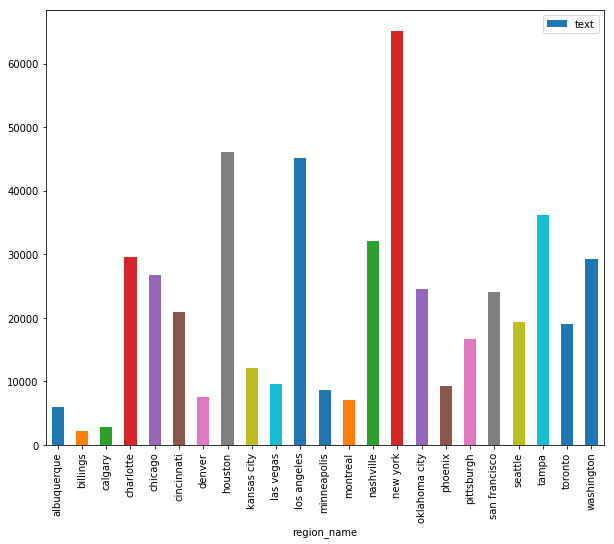

In [18]:
df_counts.plot(kind="bar", x="region_name", y="text", figsize=(10, 8))

In [54]:
target = int(df_counts[df_counts.index == 4].text)
target

26782

In [75]:
target_region_ids = [3, 4, 5, 7, 10, 13, 14, 15, 18, 19, 20, 21, 22]
target = 500000

# Create separate dataframes for each region
for x in range(len(regions)):
    name = "df_{}".format(x)
    vars()[name] = df.loc[(df.region == x)]
    if x in target_region_ids:
        target_regions.append(vars()[name])
        count = int(df_counts[df_counts.index == x].text)
        target = count if count < target else target


for region in target_regions:
    region_downsampled = resample(region, replace=False, n_samples=target, random_state=266)
    balanced_df = pd.concat([balanced_df, region_downsampled])

balanced_df.region.value_counts()

ValueError: Cannot sample 134968 out of arrays with dim 11097 when replace is False

In [77]:
region_dict = {1: "albuquerque", 2: "billings", 3: "calgary", 4: "charlotte", 5: "chicago", 6: "cincinnati", 7: "denver", 
               8: "houston", 9: "kansas city", 10: "las vegas", 11: "los angeles", 12: "minneapolis", 13: "montreal", 
               14: "nashville", 15: "new york", 16: "oklahoma city", 17: "phoenix", 18: "pittsburgh", 19: "san francisco", 
               20: "seattle", 21: "tampa", 22: "toronto", 23: "washington"}

df_counts = balanced_df.groupby('region').count()
#df_counts['region_name'] = regions
top_category_num = max(df_counts['text'])
top_category_name = df_counts[df_counts['text']==max(df_counts['text'])].index[0]
categories = df_counts.index.tolist()
#df_counts[['region_name', 'text']]
df_counts

,text
region,
3,134968
4,134968
5,134968
7,134968
10,134968
13,134968
14,134968
15,134968
18,134968


In [89]:
balanced_df.to_csv('tweets_labelled_balanced.csv', index=False, mode='w', columns=['text', 'region'], header=True)

In [66]:
import re
import nltk
from nltk.corpus import stopwords

def preprocessor(text):
    # convert to lower case
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove stop words
    stop = set(stopwords.words('english'))
    text = ' '.join(word for word in nltk.word_tokenize(text) if word not in stop)
    #print(text)
    # remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)
    # removing all digits ?
    text = re.sub(r'(\d+)', '', text)
    # remove single letter 
    text = re.sub(r'\b[a-z]\b','',text)
    # remove underscores
    text = re.sub(r'_','',text)

    return text

In [79]:
balanced_df = balanced_df.sample(frac=1)
b_sample = balanced_df[:20].copy()

In [82]:
b_sample['text'] = b_sample['text'].apply(preprocessor)

In [88]:
b_sample.iloc[2].text

' re looking work woodstock va check job schoolpsychology hiring careerarc'

In [97]:
pd.options.display.max_colwidth = 200
balanced_df.head(100)

,text,region
4161893,WE GOT THE EARTH IN THE BLUNT..,7
1049954,I’m bout to be up doing this hw assignment that was due last week. I didn’t go to class last week cause I didn’t do it. Now here we meet again &amp; I still didn’t do the shit but need to hand it...,14
1491210,"If you're looking for work in #Woodstock, VA, check out this #job: #SchoolPsychology #Hiring #CareerArc",22
975893,i have the craving for peanut butter,3
1268813,A WEIGHT has been lifted off my shoulder and I feel so great omg 😭❤️,10
3347483,i found this screenshot from a few years ago and i’m crying why am i so funny,19
2165184,"You had me with your words lost me with your actions💖\n#styledbysilvay @ Los Angeles, California",10
3969872,The lyft ride wasn’t any better. I felt in danger and I’m a lyft driver myself 😂,3
3482001,This member was happy to get a #zerowaste flu shot! Way to #conserve paper 🌳👏🏽,18
506719,Citadel - Cit-ADEL = Trends from Military Words!,3


In [95]:
df_counts.plot(kind="bar", x=df_counts.index, y="text", figsize=(10, 8))

KeyError: "Int64Index([3, 4, 5, 7, 10, 13, 14, 15, 18, 19, 20, 21, 22], dtype='int64', name='region') not in index"

In [100]:
region_dict = {0: "albuquerque", 1: "billings", 2: "calgary", 3: "charlotte", 4: "chicago", 5: "cincinnati", 6: "denver", 
               7: "houston", 8: "kansas city", 9: "las vegas", 10: "los angeles", 11: "minneapolis", 12: "montreal", 
               13: "nashville", 14: "new york", 15: "oklahoma city", 16: "phoenix", 17: "pittsburgh", 18: "san francisco", 
               19: "seattle", 20: "tampa", 21: "toronto", 22: "washington"}
df_check = pd.DataFrame()
for chunk in pd.read_csv('tweets_labelled.csv', chunksize=500000):
    print("processing chunk {}".format(chunk_counter))
    chunk_counter += 1
    df=chunk
    df.dropna(inplace=True)
    df_check = pd.concat([df_check, df.sample(10)])

df_check

processing chunk 19
processing chunk 20
processing chunk 21
processing chunk 22
processing chunk 23
processing chunk 24
processing chunk 25
processing chunk 26
processing chunk 27


,text,region
350049,What a way to start the Thanksgiving holiday. Thankful for a great win tonight against LaJoya.\nC-P-H🏈 Hornet Pride!,7
197675,💀💀💀💀 fr fr RIP Lee Thompson Young,8
43070,If Ben Simmons was a rookie Patrick Mahomes is a rookie,22
181532,Wished at 46! #theGrillnyc Thank you all for the Wishes! Thank you irenewongi for such a special birthday dinner! @ The Grill,14
239443,I’m not so average and regular,14
448232,y’all i’m at the baylor game and i just greeted people saying “howdy” and it was slightly awkward,7
112263,All of this for a shipping label lmfaoooo,3
69205,"Have a great Friday! Hey it’s all about using your Imagination! Be creative and inspire 🌈🌟✨ @ South Beach, Miami",20
151338,man i know travis scott spend some crazy bread just to have all that shit at his shows,15
402499,Santa Needs Some Help,20


In [145]:
df = pd.read_csv('tweets_labelled_balanced.csv')
df.dropna(axis=0, inplace=True)
df.region = df.region.astype(int)

In [147]:
quiz = df.sample(10000)
quiz.to_csv('10k_tweets_balanced.csv', index=False, mode='w', columns=['text', 'region'], header=True)